# **Lab 7**

## **Question 1. [20]**
In this exercise, you need to predict the life of Abalone - a kind of shellfish, based on a number of
characteristics (sex, length, diameter, height, weights in different forms, etc.). Model it as a
classification problem to predict the class (based on the number of rings). The dataset is available
[here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/). You need to use the PyTorch library to create a neural network with the following specification,
split the data and find out the accuracy on the test set after training:\
\
Decide on the hidden layer size on your own. Use sigmoid activation for the output layer and tanh for
the hidden layers. The ‘+’ Symbol represents the addition of the outputs of the 2 branches.

In [278]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.utils import shuffle
import torch
import torch.nn as nn
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

cols=['Sex','Length','Diameter','Height','Whole Weight','Shucked Weight','Viscera Weight','Shell Weight','Rings']
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 7/abalone.data',names=cols)
df['Sex'] = preprocessing.LabelEncoder().fit_transform(df['Sex'])
targets = []
for i in df['Rings']:
    if i<9:
        targets.append(0)
    elif i<11:
        targets.append(1)
    else:
        targets.append(2)
df['Rings']=targets
df.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,2
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0


In [279]:
Y = df['Rings']
X = df.iloc[:,:-1]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X))

X_train, X_test, Y_train, Y_test = tts(X, Y, test_size=0.25, random_state=0,stratify=Y)
X_train=X_train.values
Y_train=Y_train.values
X_test=X_test.values
Y_test=Y_test.values

def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [281]:
batch_size = 25
num_epochs = 500
size_hidden = 90
num_classes = 3

batch_no = len(X_train) // batch_size
nfeatures = X_train.shape[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(torch.nn.Module):
    def __init__(self, num_inputs, size_hidden, n_output):
        super().__init__()
        self.hidden_layer_1 = torch.nn.Linear(num_inputs, size_hidden)
        self.hidden_layer_2 = torch.nn.Linear(num_inputs, size_hidden)
        self.output_layer = torch.nn.Linear(size_hidden, n_output)

    def forward(self, x):
        y1 = nn.functional.tanh(self.hidden_layer_1(x))
        y2 = nn.functional.tanh(self.hidden_layer_2(x))
        sm = torch.add(y1,y2)                                            # added the outputs of the two hidden layers 
        out = nn.functional.sigmoid(self.output_layer(sm))               # and then passed it through sigmoid activation function
        return out

net = Net(nfeatures, size_hidden, num_classes)
loss_func = torch.nn.CrossEntropyLoss()

accs = []
for epoch in range(num_epochs):
    X_train, Y_train = shuffle(X_train, Y_train)

    train_acc = 0.0
    running_loss = 0.0

    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train[start:end]))
        labels = Variable(torch.LongTensor(Y_train[start:end]))
        
        learning_rate = 0.5
        if epoch>=0.4*num_epochs:
            learning_rate=0.1
        if epoch>=0.6*num_epochs:
            learning_rate=0.01
        if epoch>=0.8*num_epochs:
            learning_rate=0.005
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        acc = get_accuracy(outputs, labels, batch_size)
        train_acc += acc
    accs.append(train_acc/(i+1))
    if epoch%20==0:
        print(f'Epoch: {epoch+1} | Loss: {running_loss / (i+1):.4f} | Train Accuracy: {train_acc/(i+1):.2f} %')
    running_loss = 0.0

Epoch: 1 | Loss: 1.0109 | Train Accuracy: 52.45 %
Epoch: 21 | Loss: 0.9093 | Train Accuracy: 57.98 %
Epoch: 41 | Loss: 0.8906 | Train Accuracy: 63.84 %
Epoch: 61 | Loss: 0.8779 | Train Accuracy: 64.77 %
Epoch: 81 | Loss: 0.8761 | Train Accuracy: 64.83 %
Epoch: 101 | Loss: 0.8730 | Train Accuracy: 64.77 %
Epoch: 121 | Loss: 0.8673 | Train Accuracy: 65.41 %
Epoch: 141 | Loss: 0.8655 | Train Accuracy: 65.70 %
Epoch: 161 | Loss: 0.8625 | Train Accuracy: 65.54 %
Epoch: 181 | Loss: 0.8602 | Train Accuracy: 65.54 %
Epoch: 201 | Loss: 0.8542 | Train Accuracy: 66.18 %
Epoch: 221 | Loss: 0.8540 | Train Accuracy: 66.43 %
Epoch: 241 | Loss: 0.8542 | Train Accuracy: 66.46 %
Epoch: 261 | Loss: 0.8538 | Train Accuracy: 66.14 %
Epoch: 281 | Loss: 0.8530 | Train Accuracy: 66.40 %
Epoch: 301 | Loss: 0.8517 | Train Accuracy: 66.40 %
Epoch: 321 | Loss: 0.8517 | Train Accuracy: 66.50 %
Epoch: 341 | Loss: 0.8510 | Train Accuracy: 66.53 %
Epoch: 361 | Loss: 0.8514 | Train Accuracy: 66.40 %
Epoch: 381 | Loss:

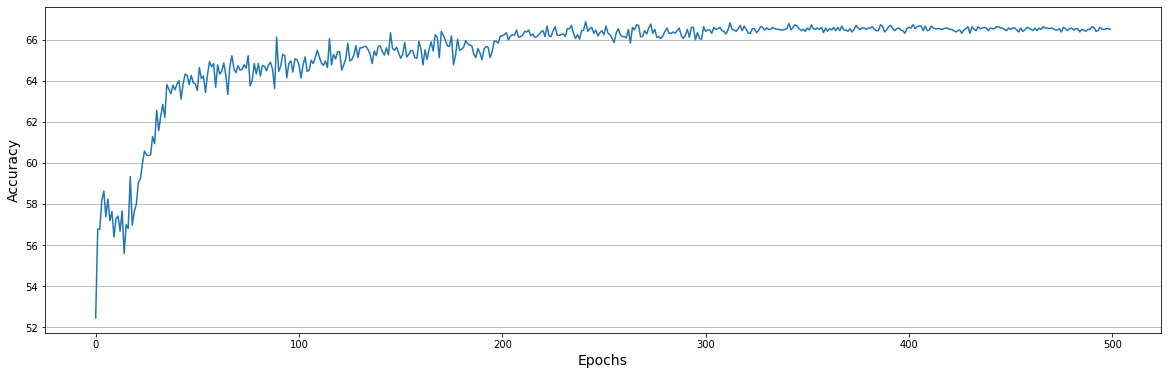

In [282]:
plt.figure(figsize=(20,6))
plt.plot(range(len(accs)),accs)
plt.grid(axis='y')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.show()

In [309]:
test_preds = torch.Tensor.detach(net.forward(Variable(torch.FloatTensor(X_test)))).numpy()
final_preds = []

for i in test_preds:
    final_preds.append(list(i).index(np.max(i)))

final_acc = metrics.accuracy_score(Y_test, final_preds) * 100
print(f'\nAccuracy on Training Dataset = {accs[-1]:.2f} %')
print(f'Accuracy on Testing Dataset = {final_acc:.2f} %')


Accuracy on Training Dataset = 66.50 %
Accuracy on Testing Dataset = 63.64 %


# **Question 2. [80]**
You have been given a dataset [here](https://archive-beta.ics.uci.edu/ml/datasets/dry+bean+dataset). It consists of different characteristics of dry beans (consider
only: area, perimeter, axes lengths, eccentricity, roundness, aspect ratio, and convex area - 8
features). You need to perform classification into different varieties (Cali, Bombay, Barbunya, etc.).
For this classification, you need to use a multi-layer perceptron.


In [318]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.utils import shuffle
import torch
import torch.nn as nn
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 7/dry_beans_dataset.txt')

a. Preprocess & visualize the data. Create train, val, and test splits but take into consideration
the class distribution \
(Hint: Look up stratified splits). ~ [5]

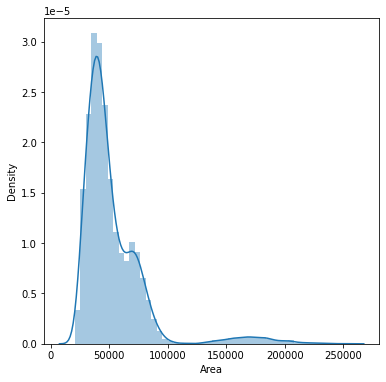

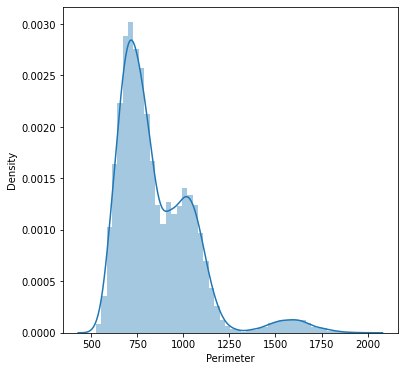

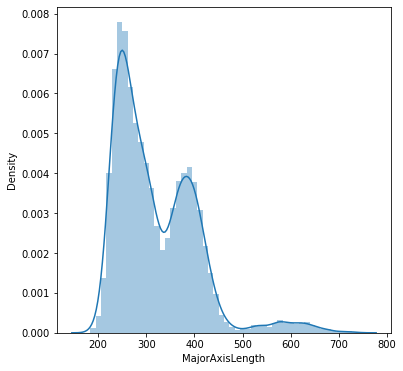

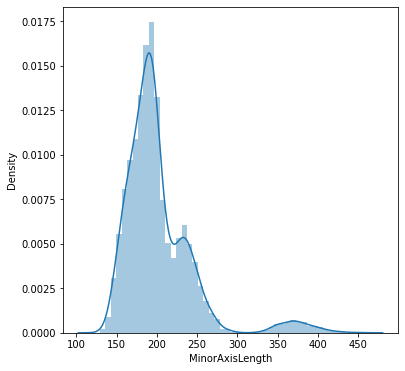

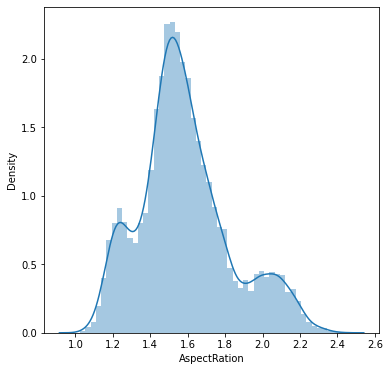

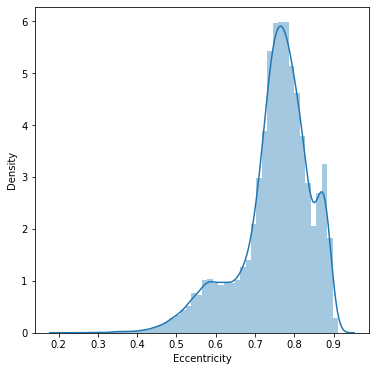

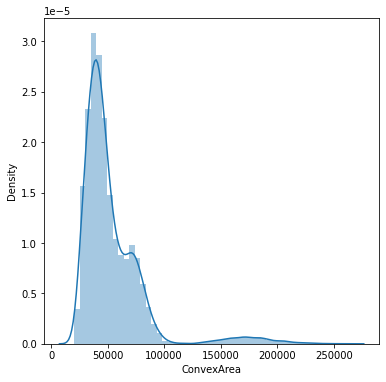

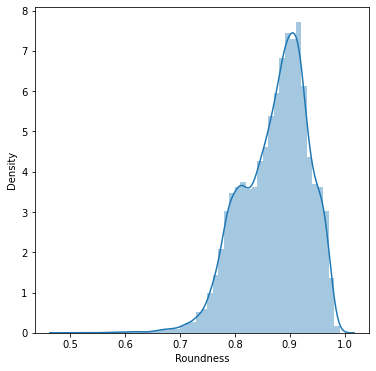

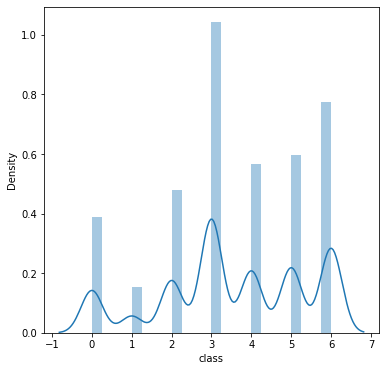

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Roundness,class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,0.958027,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,0.887034,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,0.947849,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,0.903936,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,0.984877,5


In [322]:
features = ['Area','Perimeter','MajorAxisLength','MinorAxisLength','AspectRation','Eccentricity','Roundness','ConvexArea','class']
df['class'] = preprocessing.LabelEncoder().fit_transform(df['class'])

for f in df.columns:
    plt.figure(figsize=(6,6))
    sns.distplot(df[f])
    plt.show()

    if f not in features:
        df.drop([f],axis=1,inplace=True)
    
Y = df['class']
X = df.iloc[:,:-1]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X))

X_train, X_test, Y_train, Y_test = tts(X, Y, test_size=0.25, random_state=0,stratify=Y)
X_train, X_val, Y_train, Y_val = tts(X_train, Y_train, test_size=0.2, random_state=0,stratify=Y_train)

X_train=X_train.values
Y_train=Y_train.values
X_val=X_val.values
Y_val=Y_val.values
X_test=X_test.values
Y_test=Y_test.values

df.head()


b. Implement a multi-layer perceptron from scratch. This would include the following ~[40]\
i. Write activation functions.\
ii. Forward propagate the input.\
iii. Backward propagate the error.\
iv. Train the network using stochastic gradient descent.\
v. Predict the output for a given test sample and compute the accuracy.


In [312]:
class MLP():
    def __init__(self, lr, epochs, n_hidden, weights_mode='random', activation_func='relu'):
        self.lr = lr
        self.epochs = epochs
        self.n_hidden = n_hidden
        self.weights_mode = weights_mode
        self.activation_func = activation_func

    def init_weights(self,mode='random'):

        if mode=='random':
            limit   = 1 / (self.n_features)**0.2
            self.W1  = np.random.uniform(-limit, limit, (self.n_features, self.n_hidden))
            self.b1 = np.random.uniform(-limit, limit, (1, self.n_hidden))

            limit   = 1 / (self.n_hidden)**0.3
            self.W2 = np.random.uniform(-limit, limit, (self.n_hidden, self.n_outputs))
            self.b2 = np.zeros((1, self.n_outputs))

        elif mode=='zero':
            self.W1  = np.zeros((self.n_features, self.n_hidden))
            self.b1 = np.zeros((1, self.n_hidden))

            self.W2 = np.zeros((self.n_hidden, self.n_outputs))
            self.b2 = np.zeros((1, self.n_outputs))
        
        else:
            k = float(mode.split('=')[-1])
            self.W1  = np.full((self.n_features, self.n_hidden), k)
            self.b1 = np.full((1, self.n_hidden),k)

            self.W2 = np.full((self.n_hidden, self.n_outputs), k)
            self.b2 = np.full((1, self.n_outputs), k) 

    def loss(self, target, output):
        return np.average((target - output) ** 2)

    def softmax(self,x):
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)

    def sigmoid(self, x, deriv=False):
        if deriv:
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        return 1 / (1 + np.exp(-x))
    
    def relu(self, x, deriv=False):
        if deriv:
            return 1.0 * (x > 0)
        return x * (x > 0)
    
    def tanh(self, x, deriv=False):
        if deriv:
            th = self.tanh(x)
            return 1.0 - th*th
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)) # 2.0/(1+np.exp(-2*x)) - 1.0
        
    def forward_prop(self, X):
        Z1 = np.dot(X,self.W1) + self.b1
        A1 = None

        if self.activation_func=='relu':
            A1 = self.relu(Z1)
        elif self.activation_func=='sigmoid':
            A1 = self.sigmoid(Z1)
        else:
            A1 = self.tanh(Z1)

        Z2 = np.dot(A1,self.W2) + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def one_hot(self,Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        return one_hot_Y

    def backward_prop(self,Z1, A1, Z2, A2, X, Y):
        m , n = X.shape
        one_hot_Y = self.one_hot(Y)
        dZ2 = A2 - one_hot_Y
        dW2 = 1 / m * np.dot(A1.T, dZ2)
        db2 = 1 / m * np.sum(dZ2)

        dZ1 = None
        if self.activation_func == 'relu':
            dZ1 = np.dot(dZ2, self.W2.T) * self.relu(Z1,True)
        elif self.activation_func == 'sigmoid':
            dZ1 = np.dot(dZ2, self.W2.T) * self.relu(Z1,True)
        else:
            if self.activation_func != 'tanh':
                print(f'Activation function "{self.activation_func}" is not defined so tanh is used instead')
            dZ1 = np.dot(dZ2, self.W2.T) * self.relu(Z1,True)

        dW1 = 1 / m * np.dot(X.T, dZ1)
        db1 = 1 / m * np.sum(dZ1)
        return dW1, db1, dW2, db2

    def update_params(self, dW1, db1, dW2, db2):
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def get_predictions(self,A2):
        return np.argmax(A2, axis=1)

    def get_accuracy(self,predictions, Y):
        return float(np.sum(predictions == Y) / Y.size)

    def fit(self,X,Y):                  # this function basically trains the network using stochastic gradient descent.
        self.X = X
        self.Y = Y
        self.n_samples, self.n_features = X.shape
        self.n_outputs = len(np.unique(Y))

        self.init_weights(self.weights_mode)

        train_accs = []

        for i in tqdm(range(self.epochs),'Training Progress'):
            if i==self.epochs//7:
                self.lr /= 1.5
            elif i==self.epochs//5:
                self.lr /= 1.2
            elif i==self.epochs//2:
                self.lr /= 1.1
                
            Z1, A1, Z2, A2 = self.forward_prop(self.X)

            dW1, db1, dW2, db2 = self.backward_prop(Z1, A1, Z2, A2, self.X, self.Y)
            
            self.update_params(dW1, db1, dW2, db2)
            
            predictions = self.get_predictions(A2)
            acc = self.get_accuracy(predictions, self.Y)*100
            train_accs.append(acc)
            
            # print(f'Epoch : {i+1} | Accuracy : {acc:.2f} %')
        
        return train_accs

    def predict(self,X):
        *_, A2 = self.forward_prop(X)
        predictions = self.get_predictions(A2)
        return predictions


Training Progress: 100%|██████████| 300/300 [00:52<00:00,  5.71it/s]




Accuracy on Validation Data : 89.28 %


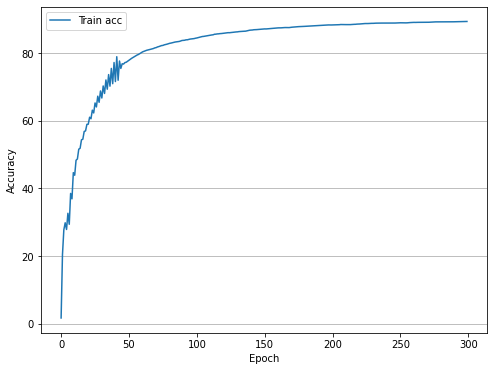

In [313]:
NN0 = MLP(lr=0.1,epochs=300,n_hidden=500,weights_mode='random',activation_func='relu')
train_accs = NN0.fit(X_train,Y_train)
preds_nn0 = NN0.predict(X_val)
print(f'\n\nAccuracy on Validation Data : {NN0.get_accuracy(preds_nn0, Y_val)*100:.2f} %')

plt.figure(figsize=(8,6))
plt.plot(range(len(train_accs)),train_accs,label="Train acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

c. Now experiment with different activation functions (at least 3 & to be written from scratch)
and comment (in the report) on how the accuracy varies. Create plots to support your
arguments. ~[10]


Training Progress: 100%|██████████| 300/300 [02:27<00:00,  2.03it/s]



Accuracy on Validation Data : 57.30 %	[ Sigmoid ]
Accuracy on Validation Data : 90.01 %	[ ReLU ]
Accuracy on Validation Data : 82.32 %	[ TanH ]


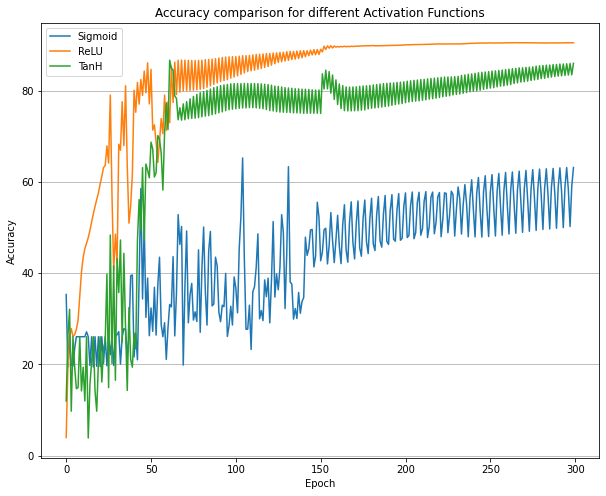

In [331]:
LR = 0.2
EPOCHS = 300
N_HIDDEN = 500

NN_sigmoid = MLP(lr=LR,epochs=EPOCHS,n_hidden=N_HIDDEN,weights_mode='random',activation_func='sigmoid')
train_accs_sigmoid = NN_sigmoid.fit(X_train,Y_train)
preds_sigmoid = NN_sigmoid.predict(X_val)
val_acc_sigmoid = NN_sigmoid.get_accuracy(preds_sigmoid, Y_val)*100

NN_relu = MLP(lr=LR,epochs=EPOCHS,n_hidden=N_HIDDEN,weights_mode='random',activation_func='relu')
train_accs_relu = NN_relu.fit(X_train,Y_train)
preds_relu = NN_relu.predict(X_val)
val_acc_relu = NN_relu.get_accuracy(preds_relu, Y_val)*100

NN_tanh = MLP(lr=LR,epochs=EPOCHS,n_hidden=N_HIDDEN,weights_mode='random',activation_func='tanh')
train_accs_tanh = NN_tanh.fit(X_train,Y_train)
preds_tanh = NN_tanh.predict(X_val)
val_acc_tanh = NN_tanh.get_accuracy(preds_tanh, Y_val)*100


print(f'\nAccuracy on Validation Data : {val_acc_sigmoid:.2f} %\t[ Sigmoid ]')
print(f'Accuracy on Validation Data : {val_acc_relu:.2f} %\t[ ReLU ]')
print(f'Accuracy on Validation Data : {val_acc_tanh:.2f} %\t[ TanH ]')


plt.figure(figsize=(10,8))
plt.title('Accuracy comparison for different Activation Functions')
plt.plot(range(len(train_accs_sigmoid)),train_accs_sigmoid,label="Sigmoid")
plt.plot(range(len(train_accs_relu)),train_accs_relu,label="ReLU")
plt.plot(range(len(train_accs_tanh)),train_accs_tanh,label="TanH")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

d. Experiment with different weight initialization: Random, Zero & Constant. Create plots to
support your arguments. ~[10]


Training Progress: 100%|██████████| 300/300 [00:36<00:00,  8.15it/s]




Accuracy on Validation Data : 89.42 %	[ Random Weights ]
Accuracy on Validation Data : 9.70 %	[ Zero Weights ]
Accuracy on Validation Data : 26.05 %	[ Constant Weights ]


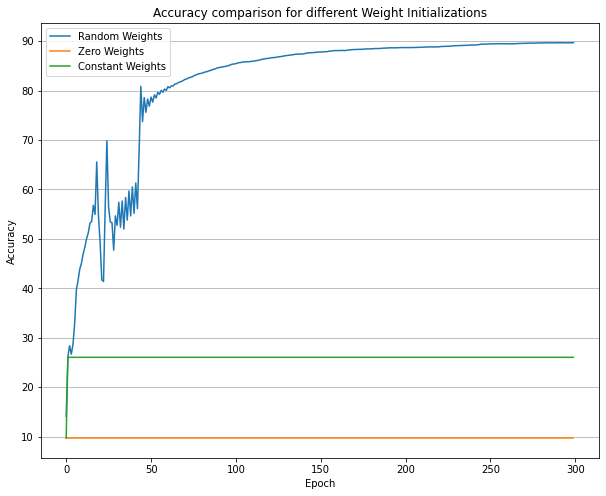

In [326]:
LR = 0.1
EPOCHS = 300
N_HIDDEN = 500

NN_random = MLP(lr=LR,epochs=EPOCHS,n_hidden=N_HIDDEN,weights_mode='random',activation_func='relu')
train_accs_random = NN_random.fit(X_train,Y_train)
preds_random = NN_random.predict(X_val)
val_acc_random = NN_random.get_accuracy(preds_random, Y_val)*100

NN_zero = MLP(lr=LR,epochs=EPOCHS,n_hidden=N_HIDDEN,weights_mode='zero',activation_func='relu')
train_accs_zero = NN_zero.fit(X_train,Y_train)
preds_zero = NN_zero.predict(X_val)
val_acc_zero = NN_zero.get_accuracy(preds_zero, Y_val)*100

NN_const = MLP(lr=LR,epochs=EPOCHS,n_hidden=N_HIDDEN,weights_mode='const=0.005',activation_func='relu')
train_accs_const = NN_const.fit(X_train,Y_train)
preds_const = NN_const.predict(X_val)
val_acc_const = NN_const.get_accuracy(preds_const, Y_val)*100


print(f'\n\nAccuracy on Validation Data : {val_acc_random:.2f} %\t[ Random Weights ]')
print(f'Accuracy on Validation Data : {val_acc_zero:.2f} %\t[ Zero Weights ]')
print(f'Accuracy on Validation Data : {val_acc_const:.2f} %\t[ Constant Weights ]')


plt.figure(figsize=(10,8))
plt.title('Accuracy comparison for different Weight Initializations')
plt.plot(range(len(train_accs_random)),train_accs_random,label="Random Weights")
plt.plot(range(len(train_accs_zero)),train_accs_zero,label="Zero Weights")
plt.plot(range(len(train_accs_const)),train_accs_const,label="Constant Weights")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

e. Change the number of hidden nodes and comment upon the training and accuracy. Create
plots to support your arguments.~[10]

Training Progress: 100%|██████████| 150/150 [00:04<00:00, 36.78it/s]




Accuracy on Validation Data : 71.65 % [ 100 Neurons in hidden layers ]


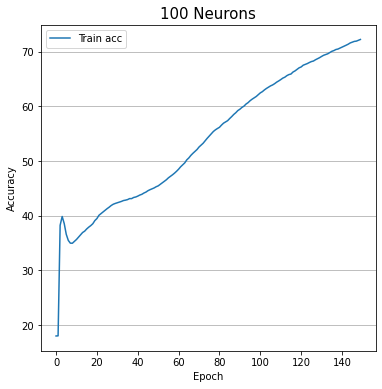

Training Progress: 100%|██████████| 150/150 [00:11<00:00, 13.12it/s]




Accuracy on Validation Data : 85.16 % [ 300 Neurons in hidden layers ]


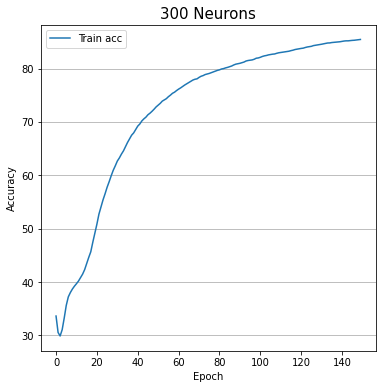

Training Progress: 100%|██████████| 150/150 [00:18<00:00,  8.02it/s]




Accuracy on Validation Data : 85.31 % [ 500 Neurons in hidden layers ]


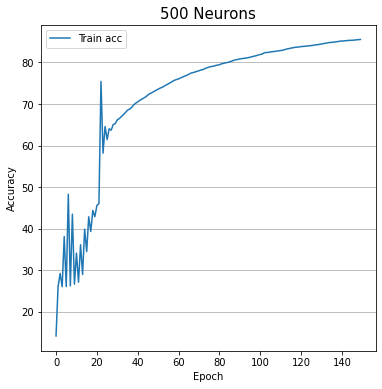

Training Progress: 100%|██████████| 150/150 [00:25<00:00,  5.92it/s]




Accuracy on Validation Data : 86.68 % [ 700 Neurons in hidden layers ]


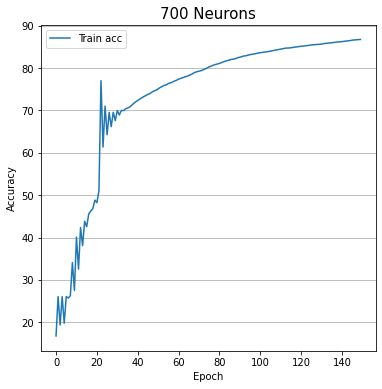

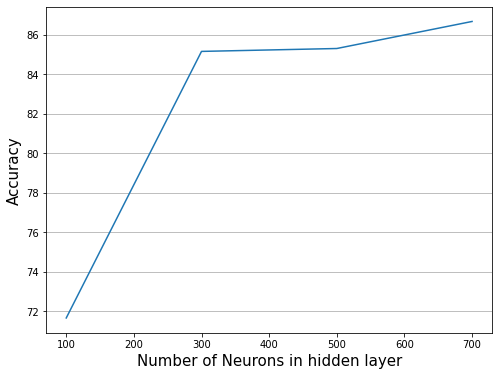

In [316]:
acc_nns = []
nns = []

for n_neurons in range(100,800,200):
    NN0 = MLP(lr=0.1,epochs=300,n_hidden=n_neurons,weights_mode='random',activation_func='relu')
    train_accs = NN0.fit(X_train,Y_train)
    preds_nn0 = NN0.predict(X_val)
    acc = NN0.get_accuracy(preds_nn0, Y_val)*100
    acc_nns.append(acc)
    nns.append(n_neurons)
    print(f'\n\nAccuracy on Validation Data : {acc:.2f} % [ {n_neurons} Neurons in hidden layers ]')

    plt.figure(figsize=(6,6))
    plt.title(f'{n_neurons} Neurons',fontsize=15)
    plt.plot(range(len(train_accs)),train_accs,label="Train acc")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(axis='y')
    plt.show()

plt.figure(figsize=(8,6))
plt.plot(nns,acc_nns)
plt.xlabel("Number of Neurons in hidden layer",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(axis='y')
plt.show()


f. Add a provision to save and load weights in the MLP. ~[5]

In [330]:
NN = MLP(lr=0.1,epochs=10,n_hidden=10,weights_mode='random',activation_func='relu')
NN.fit(X_train,Y_train)

limit   = 1 / (NN.n_features)**0.2
weights1  = np.random.uniform(-limit, limit, (NN.n_features, NN.n_hidden))
biases1 = np.random.uniform(-limit, limit, (1, NN.n_hidden))

limit   = 1 / (NN.n_hidden)**0.3
weights2 = np.random.uniform(-limit, limit, (NN.n_hidden, NN.n_outputs))
biases2 = np.zeros((1, NN.n_outputs))

NN.W1 = weights1
NN.b1 = biases1
NN.W2 = weights2
NN.b2 = biases2

print('\n\nWeights of hidden layer 2')
print(NN.W2)
print('\nBiases of hidden layer 2')
print(NN.b2)

Training Progress: 100%|██████████| 10/10 [00:00<00:00, 57.49it/s]




Weights of hidden layer 2
[[-0.18536647 -0.33167907  0.46944935 -0.24150343  0.05579619 -0.28885031
   0.2001942 ]
 [-0.21588364  0.25559813  0.18838739 -0.08841169 -0.13804327 -0.28995321
  -0.49821909]
 [ 0.05964031  0.26295755 -0.30239944  0.37116612  0.11241491  0.1527992
   0.21269083]
 [ 0.09167242 -0.04358007 -0.099779   -0.22670499 -0.13342277  0.42952798
  -0.38257738]
 [ 0.22244195 -0.3535402   0.44665309 -0.47134674 -0.22559781 -0.32067536
   0.20399576]
 [ 0.45319987 -0.26265419  0.19184158 -0.08419543 -0.31407421  0.3912685
  -0.15660982]
 [ 0.32485873  0.39779447  0.0968952  -0.31340244  0.45197661  0.09527822
   0.28630941]
 [ 0.44440301  0.07443723 -0.04408363 -0.38160673 -0.00124207 -0.04024009
  -0.42766254]
 [-0.05977325 -0.09352857 -0.02695963  0.20781907 -0.400415    0.22395851
  -0.16864685]
 [-0.14434423 -0.25206595  0.00153924  0.15905723  0.21601971  0.02880958
   0.30496988]]

Biases of hidden layer 2
[[0. 0. 0. 0. 0. 0. 0.]]


We have built a model in such a way that we can update the weights whenever we want with the attributes of the MLP() class